### Monte-Carlo Learning

In [1]:
import gym,time
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mediapy as media
from moviepy.video.io.bindings import mplfig_to_npimage
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
np.set_printoptions(precision=2,suppress=True)
plt.rc('xtick',labelsize=8); plt.rc('ytick',labelsize=8)
print ("gym:[%s]"%(gym.__version__))
print ("numpy:[%s]"%(np.__version__))
print ("matplotlib:[%s]"%(matplotlib.__version__))

gym:[0.26.2]
numpy:[1.22.4]
matplotlib:[3.7.1]


Helper Function

In [2]:
def plot_env(env,figsize=(4,4),title_str=None,title_fs=10,
             PLOT_IMG=True,RETURN_IMG=False):
    img = env.render()
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    if title_str is not None:
        plt.title(title_str,fontsize=title_fs)
    if PLOT_IMG:
        plt.show()
    # (Optional) Get image
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img
    
def visualize_matrix(M,strs='',figsize=(4,4),fontsize=10,
                     cmap='turbo',title='Title',title_fs=10,subplots_top=1.05,
                     REMOVE_TICK_LABELS=True,PLOT_IMG=True,RETURN_IMG=False):
    """
    Visualize a matrix colors and strings 
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = M.shape[0],M.shape[1]
    
    fig,ax = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(ax)
    im = ax.imshow(M,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0),
              interpolation='nearest',aspect='equal')
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    ax.set_frame_on(False)
    x,y = np.meshgrid(np.arange(0,n_col,1.0),np.arange(0,n_row,1.0))
    if len(strs) == n_row*n_col:
        idx = 0
        for x_val,y_val in zip(x.flatten(), y.flatten()):
            c = strs[idx]
            idx = idx + 1
            ax.text(x_val+0.5,y_val+0.5,c,va='center', ha='center',size=fontsize)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=subplots_top)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    if PLOT_IMG:
        plt.show()
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img
    
def display_q_value(Q,figsize=(5,5),title="Q Function",title_fs=10,text_fs=5):
    """
    Display Q value
    """
    n_state, n_action = Q.shape
    nRow = 8
    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])
    # Color
    high_color = np.array([1.0, 0.0, 0.0, 0.8])
    low_color  = np.array([1.0, 1.0, 1.0, 0.8])
    fig = plt.figure(figsize=figsize)
    plt.title(title,fontsize=title_fs)  
    for i in range(nRow):
        for j in range(nRow):
            s = i*nRow+j
            min_q = np.min(Q[s])
            max_q = np.max(Q[s])
            for a in range(n_action):
                q_value = Q[s,a]
                ratio = (q_value - min_q)/(max_q - min_q + 1e-10) 
                if ratio > 1: clr = high_color
                elif ratio < 0: clr = low_color
                else: clr = high_color*ratio + low_color*(1-ratio)
                if a == 0: # Left arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+lft_tri, color=clr, ec='k'))
                    plt.text(j-0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 1: # Down arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+dw_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i+0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 2: # Right arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+rgh_tri, color=clr, ec='k'))
                    plt.text(j+0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 3: # Up arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+up_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i-0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
    plt.xlim([-0.5,nRow-0.5])
    plt.xticks(range(nRow))
    plt.ylim([-0.5,nRow-0.5])
    plt.yticks(range(nRow))
    plt.gca().invert_yaxis()
    plt.show()
    
print ("Ready.")

Ready.


### Initialize Environment

In [3]:
env = gym.make('FrozenLake8x8-v1',render_mode='rgb_array')
env.reset()
print ("[%s] initialized."%(env.unwrapped.spec.id))

[FrozenLake8x8-v1] initialized.


In [4]:
obs_space = env.observation_space
n_state = obs_space.n
action_space = env.action_space
n_action = action_space.n
print("State space:[%d]"%(n_state))
print("Action space:[%d]"%(n_action))

State space:[64]
Action space:[4]


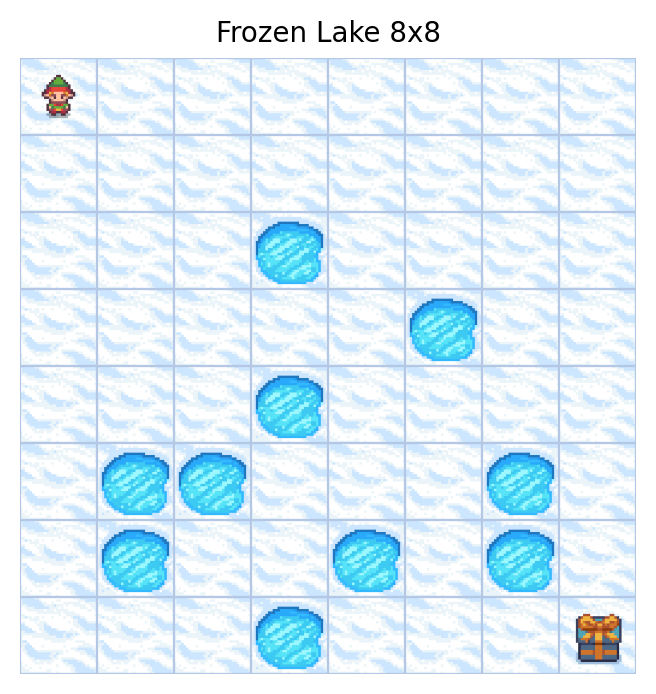

In [5]:
plot_env(env,figsize=(4,4),title_str='Frozen Lake 8x8',title_fs=10)

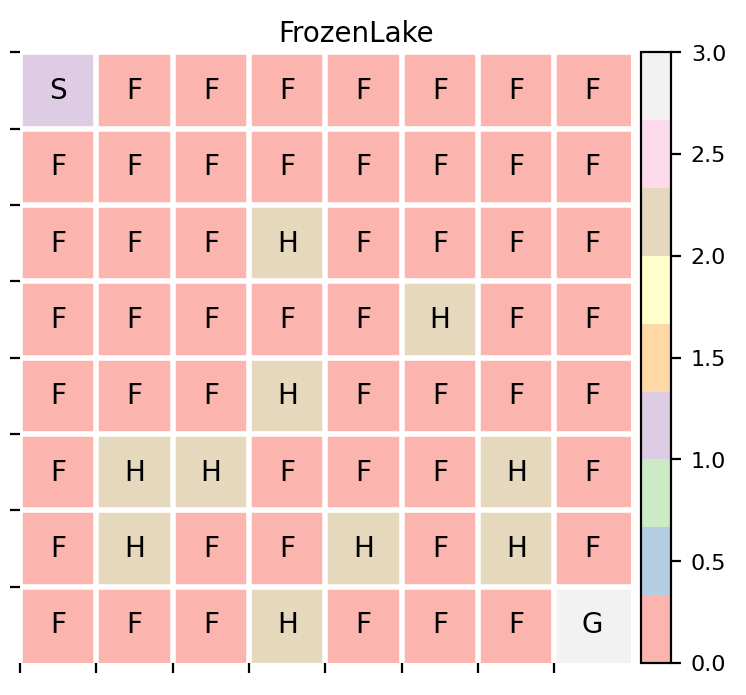

In [6]:
M = np.zeros(shape=(8,8))
strs = ['S','F','F','F','F','F','F','F',
       'F','F','F','F','F','F','F','F',
       'F','F','F','H','F','F','F','F',
       'F','F','F','F','F','H','F','F',
       'F','F','F','H','F','F','F','F',
       'F','H','H','F','F','F','H','F',
       'F','H','F','F','H','F','H','F',
       'F','F','F','H','F','F','F','G']
M[0,0] = 1 # Start
M[2,3]=M[3,5]=M[4,3]=M[5,1]=M[5,2]=M[5,6]=M[6,1]=M[6,4]=M[6,6]=M[7,3]=2 # Hole
M[7,7] = 3 # Goal
visualize_matrix(M,figsize=(4,4),fontsize=10,title_fs=10,
                 strs=strs,cmap='Pastel1',title='FrozenLake',
                 PLOT_IMG=True,RETURN_IMG=False)

### Monte Carlo Policy Iteration

For model-free policy iteration,
we need to estimate the following update using samples!!

$Q_{k+1}(s,a) = \sum_{s'} \left[r(s,a,s') + \gamma \sum_{a'} Q_{k}(s',a') \pi(a'|s') \right] P(s'|s,a)$

The update rule for Q value is changed to

$Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (G_{t} - Q_{old}(S_{t}, A_{t}))$

We can update our estimator after the episode is terminated

Given $(S_{0}, A_{0}, R_{1}, S_{1}, A_{1}, R_{2}, \dots, S_{T}, A_{T}, R_{T+1}, S_{T+1})$,

$G_{t}$ can be computed using

$G_t = R_{t+1} + \gamma G_{t+1}$

Algorithm
--
---
For every episodes

Policy Evaluation

- Initialize $Q$

- $g = 0$

- $G = Q$

- For $t = T$ to $t = 0$ (backward)

> - $g = R_{t+1} + \gamma g$
> - $G[S_{t}, A_{t}] = g$

- $Q = Q + \alpha ( G - Q )$

Policy Improvement

- $\pi(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

In [7]:
class MCAgent():
    def __init__(self,n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.995):
        """
        Initialize Monte Carlo Learning Agent 
        """
        self.n_state = n_state
        self.n_action = n_action
        self.epsilon = epsilon # epsilon greediness
        self.alpha = alpha # Q mixing rate
        self.gamma = gamma # discount factor
        
        # Initialize Q value
        self.Q = np.zeros([n_state,n_action])
        # Memory 
        self.samples = []
        
    def save_sample(self, state, action, reward, done): 
        """
        Save experience (s, a, r, done)
        """
        self.samples.append([state, action, reward, done])
        
    def update_Q(self):
        """
        Update Q
        """
        Q_old = self.Q # [S x A]
        g = 0
        G = Q_old # [S x A]
        for t in reversed(range(len(self.samples))): # for all samples in a reversed way
            state,action,reward,_ = self.samples[t]
            g = reward + self.gamma*g # g = r + gamma * g
            G[state][action] = g # update G
            
        # Update Q
        self.Q = Q_old + self.alpha*(G - Q_old) # [S x A]
        # Empty memory
        self.samples = []
        
    def update_epsilon(self,epsilon):
        self.epsilon = np.min([epsilon,1.0]) # decay
        
    def get_action(self,state):
        """
        Get action
        """
        if np.random.uniform() < self.epsilon: # random with epsilon probability 
            action = np.random.randint(0, high=self.n_action)
        else: # greedy action
            action = np.argmax(self.Q[state])
        return action

print ("Ready.")

Ready.


### Run MC Learning

MC learning done.
It took [36.09]s.


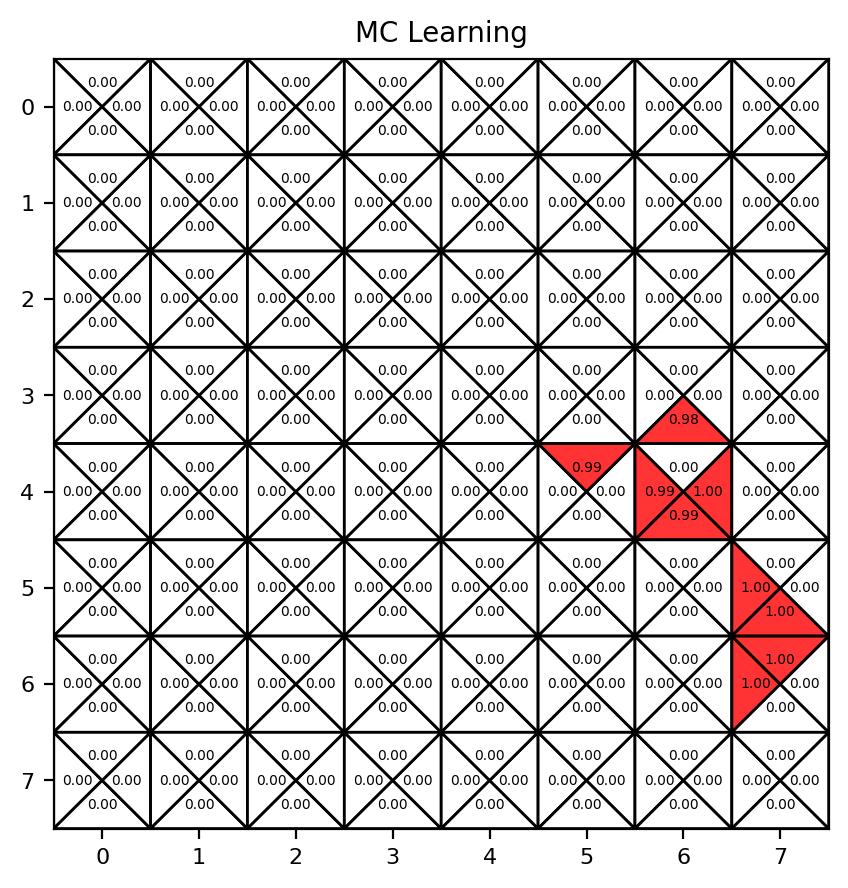

In [13]:
start = time.time()
env.reset()
n_state = env.observation_space.n
n_action = env.action_space.n
M = MCAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999)
# Loop
n_episode = 10000
for e_idx in range(n_episode):
    state,_ = env.reset() # reset environment, select initial 
    action = M.get_action(state)
    done = False
    while not done:
        next_state,reward,done,truncated,info = env.step(action) # step 
        next_action = M.get_action(next_state) # Get next action
        M.save_sample(state,action,reward,done) # Store samples
        state = next_state
        action = next_action
    # End of the episode
    M.update_Q() # Update Q value using sampled epsiode
    M.update_epsilon(100/(e_idx+1)) # Decaying epsilon
print ("MC learning done.")
print("It took [%.2f]s."%(time.time()-start))
display_q_value(M.Q, title="MC Learning",figsize=(5,5),title_fs=10,text_fs=5)

### Run MC Learning with reward shaping

MC learning done.


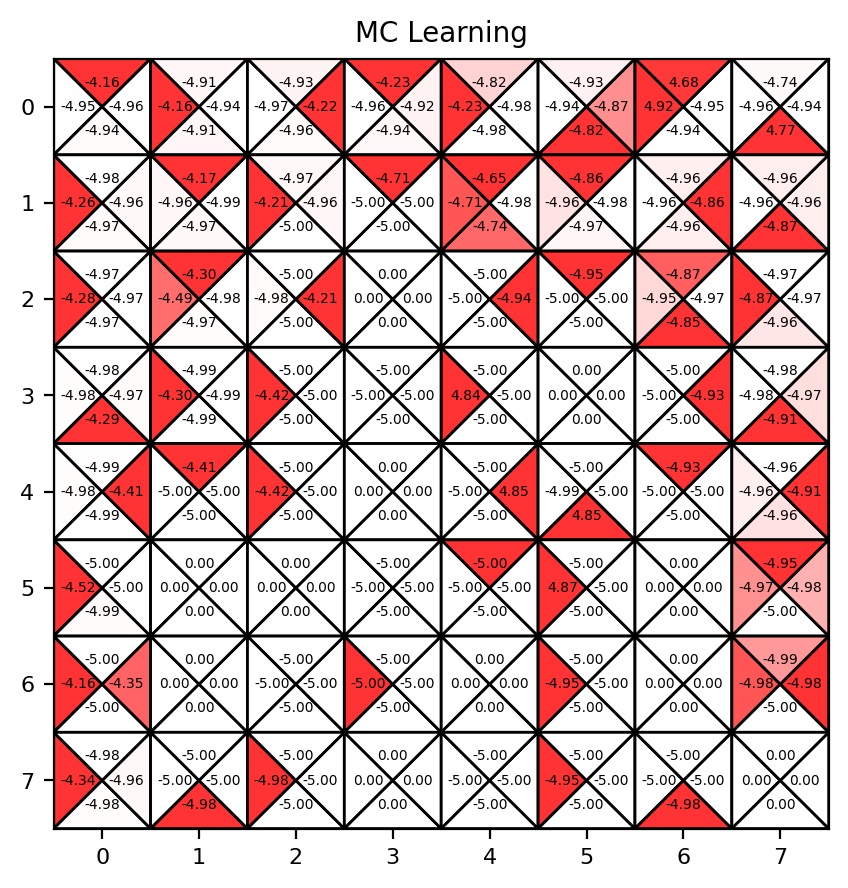

In [14]:
env.reset()
n_state = env.observation_space.n
n_action = env.action_space.n
M = MCAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999)
# Loop
n_episode = 10000
for e_idx in range(n_episode):
    state,_ = env.reset() # reset environment, select initial 
    action = M.get_action(state)
    done = False
    while not done:
        next_state,reward,done,truncated,info = env.step(action) # step 
        if done:
            # Reward modification to handle sparse reward
            if reward == 0:  
                reward = -5
            else: 
                reward = +5
        else:
            reward = -0.001 # constant negative reward
        next_action = M.get_action(next_state) # Get next action
        M.save_sample(state,action,reward,done) # Store samples
        state = next_state
        action = next_action
    # End of the episode
    M.update_Q() # Update Q value using sampled epsiode
    M.update_epsilon(100/(e_idx+1)) # Decaying epsilon
print ("MC learning done.")
display_q_value(M.Q, title="MC Learning",figsize=(5,5),title_fs=10,text_fs=5)

Animate learned policy

In [15]:
obs,_ = env.reset() # reset env
gamma = 0.99
ret,frames = 0,[]
for tick in range(1000):
    action = np.argmax(M.Q[obs])
    next_obs,reward,done,truncated,info = env.step(action)
    # Render
    title_str = "tick:[%d] action:[%s] reward:[%.2f] done:[%d]"%(
        tick,action,reward,done
    )
    img = plot_env(env,figsize=(4,4),title_str=title_str,title_fs=8,
                   PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
    obs = next_obs
    ret = reward + gamma*ret
    if done: break
env.close()
print ("Return is [%.3f] (tick:[%d])"%(ret,tick))

Return is [0.000] (tick:[85])


In [16]:
media.show_video(frames, fps=5)